# Sampling and Energy Calculation of a Water Molecule

In this tutorial we explore how to sample the density of a water molecule and compute the total energy of the system using QMC. We first import all the module we will need in the tutorial

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from qmctorch.scf import Molecule
from qmctorch.wavefunction import SlaterJastrow
from qmctorch.sampler import Metropolis
from qmctorch.solver import Solver
from qmctorch.utils.plot_data import plot_walkers_traj

INFO:QMCTorch|  ____    __  ______________             _
INFO:QMCTorch| / __ \  /  |/  / ___/_  __/__  ________/ /  
INFO:QMCTorch|/ /_/ / / /|_/ / /__  / / / _ \/ __/ __/ _ \ 
INFO:QMCTorch|\___\_\/_/  /_/\___/ /_/  \___/_/  \__/_//_/ 


## Creating the system

We now create the `Molecule` object. We use here a water molecule and load the coordinates directly from a file. We also need to specify the quantum chemistry package from which we extract the atomic and molecular orbitals information. We choose here `pyscf` and secpify  a `sto-3g`  basis set. 

In [2]:
# define the molecule
mol = Molecule(atom='water.xyz', unit='angs',
               calculator='pyscf', basis='sto-3g', name='water')

INFO:QMCTorch|
INFO:QMCTorch| SCF Calculation
INFO:QMCTorch|  Running scf  calculation
converged SCF energy = -74.9630875425187
INFO:QMCTorch|  Molecule name       : water
INFO:QMCTorch|  Number of electrons : 10
INFO:QMCTorch|  SCF calculator      : pyscf
INFO:QMCTorch|  Basis set           : sto-3g
INFO:QMCTorch|  SCF                 : HF
INFO:QMCTorch|  Number of AOs       : 7
INFO:QMCTorch|  Number of MOs       : 7
INFO:QMCTorch|  SCF Energy          : -74.963 Hartree


We can now define the wave function ansatz describing the electronic structure of the molecule. We use here a simple `SlaterJastrow` wave function and only include the ground state electronic configuration in the CI expansion. We use here the default Pade Jastrow form of the Jastrow factor. We therefore have a wave function of the type:

$$
\Psi(R) = J(R) D^0_\uparrow(r_\uparrow) D^0_\downarrow(r_\downarrow)
$$

In [3]:
wf = SlaterJastrow(mol, configs='ground_state')

INFO:QMCTorch|
INFO:QMCTorch| Wave Function
INFO:QMCTorch|  Jastrow factor      : True
INFO:QMCTorch|  Jastrow kernel      : ee -> PadeJastrowKernel
INFO:QMCTorch|  Highest MO included : 7
INFO:QMCTorch|  Configurations      : ground_state
INFO:QMCTorch|  Number of confs     : 1
INFO:QMCTorch|  Kinetic energy      : jacobi
INFO:QMCTorch|  Number var  param   : 81
INFO:QMCTorch|  Cuda support        : False


We now define the a Metropolis sampler, using only 100 walkers. Each walker contains here the positions of the 10 electrons of molecule. The electrons are initially localized around their atomic center, i.e. 8 around the oxygen atom and 1 around each hydrogen atom. We also specify here that the sampler will perform 500 steps with a step size of 0.25 bohr. 

In [4]:
sampler = Metropolis(nwalkers=100, nstep=500, step_size=0.25,
                     nelec=wf.nelec, ndim=wf.ndim,
                     init=mol.domain('atomic'),
                     move={'type': 'all-elec', 'proba': 'normal'})

INFO:QMCTorch|
INFO:QMCTorch| Monte-Carlo Sampler
INFO:QMCTorch|  Number of walkers   : 100
INFO:QMCTorch|  Number of steps     : 500
INFO:QMCTorch|  Step size           : 0.25
INFO:QMCTorch|  Thermalization steps: -1
INFO:QMCTorch|  Decorelation steps  : 1
INFO:QMCTorch|  Walkers init pos    : atomic
INFO:QMCTorch|  Move type           : all-elec
INFO:QMCTorch|  Move proba          : normal


We can finally initialize the solver that will run the calculation

In [5]:
solver = Solver(wf=wf, sampler=sampler)

INFO:QMCTorch|
INFO:QMCTorch| QMC Solver 
INFO:QMCTorch|  WaveFunction        : SlaterJastrow
INFO:QMCTorch|  Sampler             : Metropolis


## Sampling the density
We can use the wave function and the sampler we just defined to obtain sample of the electronic density. We can for example then plot the positions of the individual electrons in the plane of the molecule to vizually inspect the result of the sampling.

INFO:QMCTorch|  Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 187.74it/s]

INFO:QMCTorch|   Acceptance rate     : 2.66 %
INFO:QMCTorch|   Timing statistics   : 187.66 steps/sec.
INFO:QMCTorch|   Total Time          : 2.66 sec.


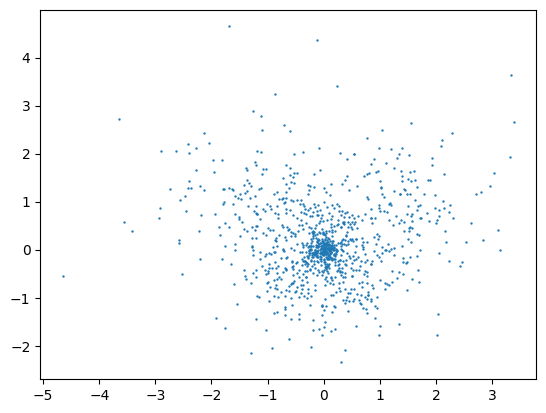

In [6]:
pos = sampler(wf.pdf)
pos = pos.reshape(100,10,3).cpu().detach().numpy()
plt.scatter(pos[:,:,0],pos[:,:,1],s=0.5)

## Following indiviudal electron path
By default the sampler only record the position of the electrons at the very last step of the sampling process. We can however change and record all the positions of the electrons during the sampling to be able to track them.  

In [7]:
sampler_singlewalker = Metropolis(nwalkers=1, nstep=500, step_size=0.25,
                     nelec=wf.nelec, ndim=wf.ndim,
                     ntherm=0, ndecor=1,
                     init=mol.domain('atomic'),
                     move={'type': 'all-elec', 'proba': 'normal'})

INFO:QMCTorch|
INFO:QMCTorch| Monte-Carlo Sampler
INFO:QMCTorch|  Number of walkers   : 1
INFO:QMCTorch|  Number of steps     : 500
INFO:QMCTorch|  Step size           : 0.25
INFO:QMCTorch|  Thermalization steps: 0
INFO:QMCTorch|  Decorelation steps  : 1
INFO:QMCTorch|  Walkers init pos    : atomic
INFO:QMCTorch|  Move type           : all-elec
INFO:QMCTorch|  Move proba          : normal


INFO:QMCTorch|  Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 897.20it/s]

INFO:QMCTorch|   Acceptance rate     : 3.60 %
INFO:QMCTorch|   Timing statistics   : 895.57 steps/sec.
INFO:QMCTorch|   Total Time          : 0.56 sec.


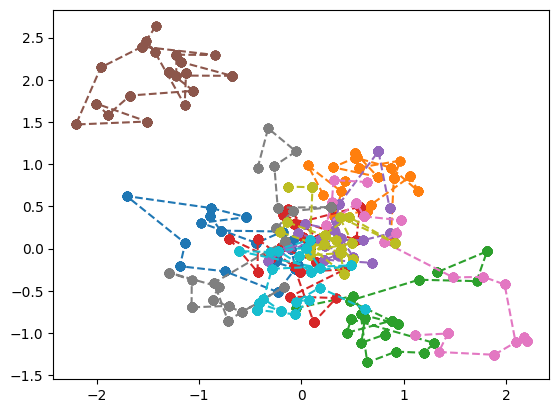

In [8]:
pos = sampler_singlewalker(wf.pdf)
pos = pos.reshape(-1,10,3).detach().numpy()
plt.plot(pos[:,:,0], pos[:,:,1], marker="o", ls='--')

## Energy Calculation
To compute the energy of the system we first need to create a solver object that will handle all the orchestration of the calculation

In [9]:
solver = Solver(wf=wf, sampler=sampler)

INFO:QMCTorch|
INFO:QMCTorch| Warning : dump to hdf5
INFO:QMCTorch| Object Solver already exists in water_pyscf_sto-3g_QMCTorch.hdf5
INFO:QMCTorch| Object name changed to Solver_2
INFO:QMCTorch|
INFO:QMCTorch|
INFO:QMCTorch| QMC Solver 
INFO:QMCTorch|  WaveFunction        : SlaterJastrow
INFO:QMCTorch|  Sampler             : Metropolis


The energy can then be directly calculated

In [10]:
obs = solver.single_point()

INFO:QMCTorch|
INFO:QMCTorch|  Single Point Calculation : 100 walkers | 500 steps


INFO:QMCTorch|  Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 535.45it/s]

INFO:QMCTorch|   Acceptance rate     : 2.64 %
INFO:QMCTorch|   Timing statistics   : 534.84 steps/sec.
INFO:QMCTorch|   Total Time          : 0.93 sec.
INFO:QMCTorch|  Energy   : -76.697502 +/- 4.330277
INFO:QMCTorch|  Variance : 1875.130127


## Sampling Trajectory
We can also follow how the total energy thermalize during the sampling process. To this end we need to record the positions of the walkers during the sampling and not just at the end of it. We can then compute the local energies and the total energy at each recorded step of the trajectory. We can either create a new sampler or simply change the configuration of the sampler already included in our solver. We will put the number of thermalization steps to 0 and the number of decorellation step to 5.

In [11]:
solver.sampler.ntherm = 0
solver.sampler.ndecor = 5

We can then resample the density and compute the local energy values along the sampling trajectory and finnaly plot it.

INFO:QMCTorch|  Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 205.41it/s]


INFO:QMCTorch|   Acceptance rate     : 2.50 %
INFO:QMCTorch|   Timing statistics   : 205.32 steps/sec.
INFO:QMCTorch|   Total Time          : 2.44 sec.
INFO:QMCTorch|
INFO:QMCTorch|  Sampling trajectory


INFO:QMCTorch|  Energy  : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.11it/s]


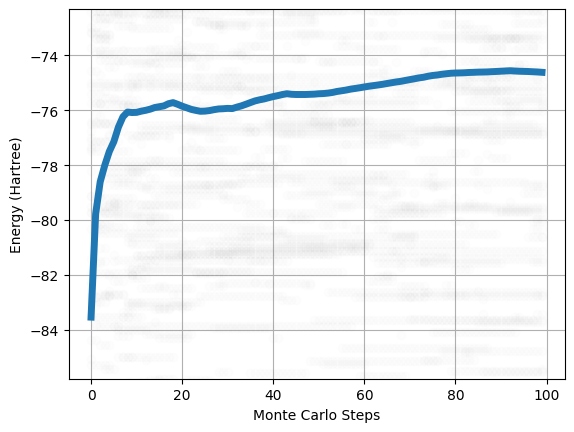

In [12]:
pos = solver.sampler(solver.wf.pdf)
obs = solver.sampling_traj(pos)
plot_walkers_traj(obs.local_energy, walkers='mean')